In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler

In [8]:
# loading the dataset
perf_df = pd.read_csv('NBA_Perf_22.csv', encoding='latin1')
sal_df = pd.read_csv('nba_salaries_22.csv', encoding='latin1')

In [9]:
def prepare_nba_data(perf_df, sal_df):
    # Step 1: Rename salary dataframe columns
    sal_df.columns = ['Player', 'Salary']
    
    # Step 2: Clean the Salary column BEFORE merging
    sal_df['Salary'] = sal_df['Salary'].str.replace('$', '', regex=False).str.replace(',', '', regex=False).astype(float)
    
    # Step 3: Merge performance and salary data
    df = perf_df.merge(sal_df, how='inner', on='Player')
    
    # Step 4: Fill missing values in performance data with column means
    columns_with_nulls = df.columns[df.isnull().any()].tolist()
    for col in columns_with_nulls:
        df[col] = df[col].fillna(df[col].mean())
    
    df = df.drop_duplicates(subset=['Player'])
    return df

df = prepare_nba_data(perf_df, sal_df)
df.head(10)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Salary
0,Precious Achiuwa,C,22,TOR,73,28,23.6,3.6,8.3,0.439,...,2.0,4.5,6.5,1.1,0.5,0.6,1.2,2.1,9.1,2840160.0
1,Steven Adams,C,28,MEM,76,75,26.3,2.8,5.1,0.547,...,4.6,5.4,10.0,3.4,0.9,0.8,1.5,2.0,6.9,17926829.0
2,Bam Adebayo,C,24,MIA,56,56,32.6,7.3,13.0,0.557,...,2.4,7.6,10.1,3.4,1.4,0.8,2.6,3.1,19.1,30351780.0
3,Santi Aldama,PF,21,MEM,32,0,11.3,1.7,4.1,0.402,...,1.0,1.7,2.7,0.7,0.2,0.3,0.5,1.1,4.1,2094120.0
4,Nickeil Alexander-Walker,SG,23,TOT,65,21,22.6,3.9,10.5,0.372,...,0.6,2.3,2.9,2.4,0.7,0.4,1.4,1.6,10.6,5009633.0
7,Grayson Allen,SG,26,MIL,66,61,27.3,3.9,8.6,0.448,...,0.5,2.9,3.4,1.5,0.7,0.3,0.7,1.5,11.1,8500000.0
8,Jarrett Allen,C,23,CLE,56,56,32.3,6.6,9.7,0.677,...,3.4,7.3,10.8,1.6,0.8,1.3,1.7,1.7,16.1,20000000.0
9,Jose Alvarado,PG,23,NOP,54,1,15.4,2.4,5.4,0.446,...,0.5,1.4,1.9,2.8,1.3,0.1,0.7,1.4,6.1,1563518.0
10,Kyle Anderson,PF,28,MEM,69,11,21.5,3.0,6.8,0.446,...,1.0,4.3,5.3,2.7,1.1,0.7,1.0,1.6,7.6,8780488.0
11,Giannis Antetokounmpo,PF,27,MIL,67,67,32.9,10.3,18.6,0.553,...,2.0,9.6,11.6,5.8,1.1,1.4,3.3,3.2,29.9,42492492.0


In [14]:
# Step 1: Select only Player, Pos, Salary, and the 3 features (PTS, AST, TOV)
features_to_keep = ['Player', 'Pos', 'Salary', 'PTS', 'AST', 'TOV']
df = df[features_to_keep]

In [15]:
from sklearn.preprocessing import StandardScaler

# Step 2: Scale only the 3 chosen features
features_to_scale = ['PTS', 'AST', 'TOV']

scaler = StandardScaler()
df_scaled_features = scaler.fit_transform(df[features_to_scale])

# Make a new scaled dataframe
df_scaled = pd.DataFrame(df_scaled_features, columns=features_to_scale)
df_scaled['Player'] = df['Player'].values
df_scaled['Pos'] = df['Pos'].values
df_scaled['Salary'] = df['Salary'].values


In [20]:
from sklearn.cluster import KMeans

# Step 3: Run initial KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(df_scaled[['PTS', 'AST', 'TOV']])

# Add cluster labels back to the scaled DataFrame
df_scaled['Cluster'] = kmeans.labels_


In [21]:
import plotly.express as px

# Step 4: 3D plot
fig = px.scatter_3d(
    df_scaled, 
    x='PTS', 
    y='AST', 
    z='TOV', 
    color='Cluster',
    title='NBA Players Clustering Based on PTS, AST, TOV',
    labels={'PTS': 'Points', 'AST': 'Assists', 'TOV': 'Turnovers'},
    color_continuous_scale=px.colors.sequential.Viridis
)
fig.update_traces(marker=dict(size=5, opacity=0.8))
fig.show()


In [22]:
from sklearn.metrics import silhouette_score
import numpy as np

# Total Variance Explained
total_sum_squares = np.sum((df_scaled[['PTS', 'AST', 'TOV']] - np.mean(df_scaled[['PTS', 'AST', 'TOV']]))**2)
total = np.sum(total_sum_squares)
between_SSE = (total - kmeans.inertia_)
var_explained = between_SSE / total

print(f'Total Variance Explained: {var_explained:.4f}')

# Silhouette Score
silhouette_avg = silhouette_score(df_scaled[['PTS', 'AST', 'TOV']], df_scaled['Cluster'])
print(f'Silhouette Score: {silhouette_avg:.4f}')


Total Variance Explained: 0.7500
Silhouette Score: 0.4341


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)



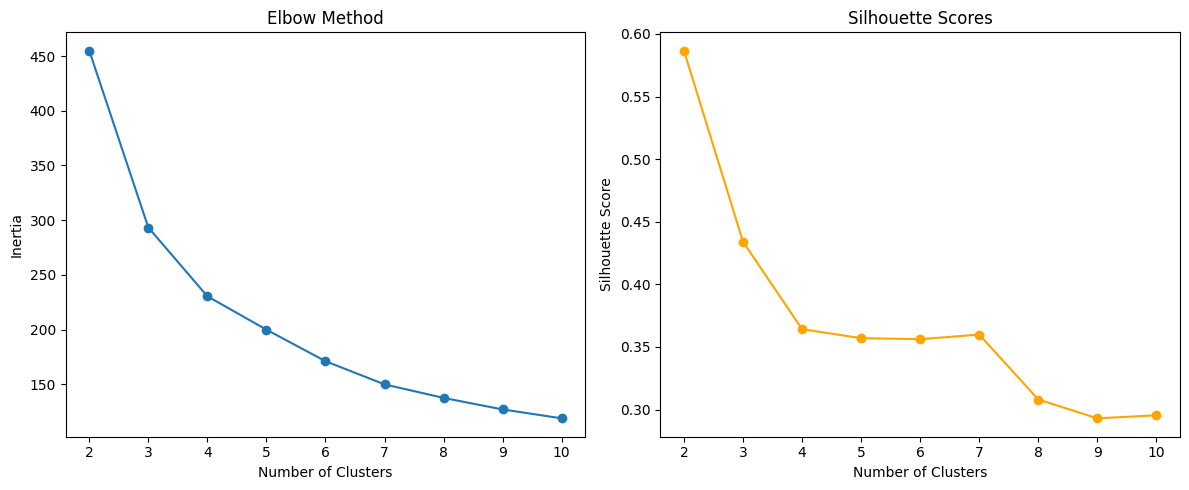

In [23]:
# Elbow Method
inertia_list = []
silhouette_scores = []

for k in range(2, 11):
    kmeans_temp = KMeans(n_clusters=k, random_state=1)
    kmeans_temp.fit(df_scaled[['PTS', 'AST', 'TOV']])
    inertia_list.append(kmeans_temp.inertia_)
    
    sil_score = silhouette_score(df_scaled[['PTS', 'AST', 'TOV']], kmeans_temp.labels_)
    silhouette_scores.append(sil_score)

import matplotlib.pyplot as plt

# Plot Elbow
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(2,11), inertia_list, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

# Plot Silhouette
plt.subplot(1,2,2)
plt.plot(range(2,11), silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()


In [24]:
# Retrain final KMeans with k=2
kmeans_final = KMeans(n_clusters=2, random_state=1)
kmeans_final.fit(df_scaled[['PTS', 'AST', 'TOV']])

# Assign final clusters
df_scaled['Final_Cluster'] = kmeans_final.labels_

# Final 3D Visualization
fig = px.scatter_3d(
    df_scaled, 
    x='PTS', 
    y='AST', 
    z='TOV', 
    color='Final_Cluster',
    title='Final NBA Players Clustering (k=2)',
    labels={'PTS': 'Points', 'AST': 'Assists', 'TOV': 'Turnovers'},
    color_continuous_scale=px.colors.sequential.Viridis
)
fig.update_traces(marker=dict(size=5, opacity=0.8))
fig.show()


In [25]:
# Evaluate final model
total_sum_squares_final = np.sum((df_scaled[['PTS', 'AST', 'TOV']] - np.mean(df_scaled[['PTS', 'AST', 'TOV']]))**2)
total_final = np.sum(total_sum_squares_final)
between_SSE_final = (total_final - kmeans_final.inertia_)
var_explained_final = between_SSE_final / total_final

print(f'Final Total Variance Explained: {var_explained_final:.4f}')

silhouette_final = silhouette_score(df_scaled[['PTS', 'AST', 'TOV']], df_scaled['Final_Cluster'])
print(f'Final Silhouette Score: {silhouette_final:.4f}')


Final Total Variance Explained: 0.6122
Final Silhouette Score: 0.5866


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)

